In [ ]:
!apt install cuda
!pip install pytorch_forecasting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pytorch_forecasting.metrics import MAE, RMSE, MAPE

warnings.filterwarnings('ignore')


def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 15 08:22:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    36W / 250W |    747MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-01-01 00:00:00']

In [ ]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          if corridor_tt_2021['5 Minutes'].duplicated().any() :  # to avoid duplicates cause by primary and secondary route
            print(corridor["Corridor"], " ", corridor["Fwy-Dir"])
            continue
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [ ]:
# all_corridors_tt_2021

In [ ]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77743,2021-10-31 23:35:00,10.93,11.63,10.82,4.12,4.08,1.27,1.30,13.12,15.40,...,14.00,13.97,18.42,18.78,25.77,25.60,5.75,5.92,15.73,15.82
77744,2021-10-31 23:40:00,10.92,11.63,10.83,4.13,4.08,1.25,1.32,13.08,15.50,...,14.00,13.97,18.40,18.82,25.77,25.82,5.73,5.92,15.73,15.90
77745,2021-10-31 23:45:00,10.88,11.62,10.93,4.13,4.08,1.28,1.30,13.05,15.25,...,14.00,13.95,18.40,18.82,25.82,25.73,5.73,5.90,15.75,15.85
77746,2021-10-31 23:50:00,10.88,11.60,10.83,4.13,4.07,1.27,1.30,13.03,14.87,...,13.98,13.97,18.40,18.83,25.80,25.60,5.73,6.03,15.73,15.75


In [ ]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [ ]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,...,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
5,2021-01-27 00:25:00,11.00,11.70,11.15,4.13,4.28,1.27,1.27,13.35,13.17,...,13.97,13.85,18.45,18.72,26.15,25.97,5.80,5.98,16.13,16.02
6,2021-01-27 00:30:00,11.02,11.68,11.17,4.13,4.17,1.27,1.27,13.40,13.15,...,13.97,13.85,18.45,18.72,26.03,25.97,5.78,5.92,16.02,15.98
7,2021-01-27 00:35:00,10.98,11.68,11.37,4.30,4.13,1.27,1.27,13.35,13.12,...,13.97,13.85,18.45,18.72,26.00,25.85,5.80,5.87,15.97,15.95
8,2021-01-27 00:40:00,10.93,11.68,11.18,4.23,4.20,1.27,1.27,13.28,13.10,...,14.00,13.85,18.45,18.73,25.95,25.77,5.78,6.32,15.97,15.90
9,2021-01-27 00:45:00,10.95,11.70,11.02,4.17,4.15,1.27,1.27,13.35,13.13,...,13.98,13.85,18.45,18.73,25.83,25.78,5.80,6.75,15.93,15.92


In [ ]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
# print(total_data)

In [ ]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]
total = total_data.to_numpy()
# scaler = MinMaxScaler(feature_range=(0,1))
# total = scaler.fit_transform(total_data)
# # train = scaler.transform(train_data)
# total = scaler.transform(total_data)

# sc = MinMaxScaler()
# total_data = sc.fit_transform(total_data)

## 15 minutes horizon
trn_x_15min, trn_y_15min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 2)  #every 2 hours.
vld_x_15min, vld_y_15min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 2)  #every 2 hours.
tst_x_15min, tst_y_15min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 2)  #every 2 hours.

trn_x_15min = trn_x_15min.reshape(-1,time_steps, num_corridor)
vld_x_15min = vld_x_15min.reshape(-1,time_steps, num_corridor)
tst_x_15min = tst_x_15min.reshape(-1,time_steps, num_corridor)


## 30 minutes horizon
trn_x_30min, trn_y_30min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 5)  #every 2 hours.
vld_x_30min, vld_y_30min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 5)  #every 2 hours.
tst_x_30min, tst_y_30min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 5)  #every 2 hours.

trn_x_30min = trn_x_30min.reshape(-1,time_steps, num_corridor)
vld_x_30min = vld_x_30min.reshape(-1,time_steps, num_corridor)
tst_x_30min = tst_x_30min.reshape(-1,time_steps, num_corridor)


## 45 minutes horizon
trn_x_45min, trn_y_45min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 8)  #every 2 hours.
vld_x_45min, vld_y_45min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 8)  #every 2 hours.
tst_x_45min, tst_y_45min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 8)  #every 2 hours.

trn_x_45min = trn_x_45min.reshape(-1,time_steps, num_corridor)
vld_x_45min = vld_x_45min.reshape(-1,time_steps, num_corridor)
tst_x_45min = tst_x_45min.reshape(-1,time_steps, num_corridor)


In [ ]:
# conver the data to tensors and pass to the Dataloader 
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
class SelfAttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
    
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
      
        attention_weight:
            att_w : size (N, T, 1)
    
        return:
            utter_rep: size (N, H)
        """
        
        softmax = nn.functional.softmax
        att_w = softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep


# A custom attention layer
class SelfAttention(nn.Module):
    def __init__(self, attention_size, att_hops, non_linearity="tanh"):
        super(SelfAttention, self).__init__()

        self.ut_dense =  nn.Sequential(
                nn.Linear(hidden_size, attention_size),
                nn.Tanh()
         )
        
        self.et_dense = nn.Linear(attention_size, att_hops)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        ##################################################################
        # STEP 1 - perform dot product
        # of the attention vector and each hidden state
        ##################################################################

        # inputs is a 3D Tensor: batch, len, hidden_size
        # scores is a 2D Tensor: batch, len
        ut = self.ut_dense(inputs)

        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        att_scores = self.softmax(torch.permute(et, (0, 2, 1)))

        # # re-normalize the masked scores
        # _sums = scores.sum(-1, keepdim=True)  # sums per row
        # att_scores = scores.div(_sums)  # divide by row sum

        ##################################################################
        # Step 2 - Weighted sum of hidden states, by the attention scores
        ##################################################################
        
        # print("att_scores.shape: ", att_scores.shape, "inputs.shape", inputs.shape)

        # multiply each hidden state with the attention weights
        output = torch.bmm(att_scores, inputs)

        return output, att_scores

In [ ]:
class HierLstmat(nn.Module):

    def __init__(self, num_corridor, hidden_size, num_layers, natt_unit, natt_hops, nfc):
        super(HierLstmat, self).__init__()

        self.input_size = num_corridor
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_len = 0
    
        # Initialize LSTM Cell for the first layer
        self.lstm_cell_layer_1 = nn.LSTMCell(self.input_size, self.hidden_size)

        # Initialize LSTM Cell for the second layer
        self.lstm_cell_layer_2 = nn.LSTMCell(self.hidden_size, self.hidden_size)

        # default maximum upgrade length
        self.up_len = 80      

        # flattern
        self.handle_hops = nn.Sequential(
            nn.Flatten()
            )

        # output layer
        self.output_layer =  nn.Sequential(
            nn.Linear(self.hidden_size * natt_hops, nfc),
            nn.ReLU(),
            nn.Linear(nfc, num_corridor)
        )

        # attention layer
        self.att_encoder = SelfAttention(natt_unit, natt_hops)      
        
        # attention pooling layer
        self.att_pooling = SelfAttentionPooling(self.hidden_size)

    def forward(self, x):

      self.sequence_len = x.shape[1]
      batch_Size = x.shape[0]
      sequence_input = x.transpose(0, 1)

      # print("sequence_input.device: ", sequence_input.device)
      
      # batch_size x hidden_size
      hidden_state = torch.zeros(batch_Size, self.hidden_size).to(device)
      cell_state = torch.zeros(batch_Size, self.hidden_size).to(device)
      hidden_state_2 = torch.zeros(batch_Size, self.hidden_size).to(device)
      cell_state_2 = torch.zeros(batch_Size, self.hidden_size).to(device)

      # print("hidden_state.device: ", hidden_state.device)
      
      # weights initialization
      torch.nn.init.xavier_normal_(hidden_state)
      torch.nn.init.xavier_normal_(cell_state)
      torch.nn.init.xavier_normal_(hidden_state_2)
      torch.nn.init.xavier_normal_(cell_state_2)

      # set upgrade length
      up_len = min(self.up_len, math.floor(math.sqrt(self.sequence_len)))
      # evenly spaced index
      idx = np.linspace(up_len - 1, math.pow(up_len, 2) - 1, num = up_len)
      # print("sequence index: ", idx)

      # initiate pooling hidden_sates an cell states
      interverl_hidden_states = torch.empty(batch_Size, self.hidden_size, device = device)
      interverl_cell_states = torch.empty(batch_Size, self.hidden_size, device = device)
      outer_hidden_states = torch.empty(batch_Size, self.hidden_size, device = device)
      outer_cell_states = torch.empty(batch_Size, self.hidden_size, device = device)
      
      # Unfolding LSTM
      # Last hidden_state will be used to feed the fully connected neural net
      for i in range(self.sequence_len):
        
        hidden_state, cell_state = self.lstm_cell_layer_1(sequence_input[i], (hidden_state, cell_state))

        if  torch.isnan(interverl_hidden_states).sum() == 0 :
            interverl_hidden_states = hidden_state[None, :]
            interverl_cell_states = cell_state[None, :]

        else:
            interverl_hidden_states = torch.cat((interverl_hidden_states, hidden_state[None, :]), 0) # TimeSteps * Batch  * Feature
            interverl_cell_states = torch.cat((interverl_cell_states, cell_state[None, :]), 0)       # TimeSteps * Batch  * Feature
            # print("interverl_hidden_states: ", interverl_hidden_states.shape)

        if i in idx or (i == self.sequence_len - 1):

            interverl_hidden_states = interverl_hidden_states.transpose(0,1)
            interverl_cell_states = interverl_cell_states.transpose(0,1)

            # print("interverl_hidden_states: ", interverl_hidden_states.shape)
            # print("interverl_cell_states: ", interverl_cell_states.shape)

            layer1_cell_states = torch.cat((interverl_cell_states, cell_state_2[None, :].transpose(0,1)), 1)       # Batch * (TimeSteps + 1) * Feature

            layer2_input = self.att_pooling(interverl_hidden_states)   # Batch * Feature
            cell_state_2 = self.att_pooling(layer1_cell_states)       # Batch * Feature
            
            hidden_state_2, cell_state_2 = self.lstm_cell_layer_2(layer2_input, (hidden_state_2, cell_state_2))
            interverl_hidden_states = torch.empty(batch_Size, self.hidden_size, device = device)
            interverl_cell_states = torch.empty(batch_Size, self.hidden_size, device = device)

            if torch.isnan(outer_hidden_states).sum() == 0:
              outer_hidden_states = hidden_state_2[None, :]
            else:
              outer_hidden_states = torch.cat((outer_hidden_states, hidden_state_2[None, :]))  # # Sequence * Batch  * hiddensize

      up_x = torch.transpose(outer_hidden_states, 1, 0)   # size: (batch, Sequence, hiddensize)
      # print("up_x.shape: ", up_x.shape)   # up_x.shape:  torch.Size([250, 120])
      # print("reshaped up_x: ", up_x.view(batch_Size, -1, self.hidden_size).shape)   # reshaped up_x:  torch.Size([batch_size, sample_Size, hidden_size])

      att_output, att_scores = self.att_encoder(up_x.view(batch_Size, -1, self.hidden_size))
      # att_output shape [batch_size, att_hops, LSTM_nhidden]

      att_output_flattern = self.handle_hops(att_output)  # [batch_size, att_hops * LSTM_nhidden]
      # print("att_output_flattern: ", att_output_flattern.shape)

      # Last hidden state is passed through a fully connected neural net
      output = self.output_layer(att_output_flattern)
      
      return output

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstmat(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

inputs = torch.randn(batch_size, 48, num_corridor).to(device)

y_pred = model(inputs)


## 15 minutes Horizon

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_15min)))
trainY = Variable(torch.Tensor(np.array(trn_y_15min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_15min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_15min)))

testX = Variable(torch.Tensor(np.array(tst_x_15min)))
testY = Variable(torch.Tensor(np.array(tst_y_15min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

print(device)

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_15min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = scaler.inverse_transform(y_pred)
            # targets = scaler.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

cuda:0
epoch: 10 | trn_loss: 0.79607413 val_loss: 0.72543999 
epoch: 20 | trn_loss: 0.48407087 val_loss: 0.47852132 
epoch: 30 | trn_loss: 0.36052834 val_loss: 0.36098687 
epoch: 40 | trn_loss: 0.29872425 val_loss: 0.30487633 
epoch: 50 | trn_loss: 0.25987005 val_loss: 0.26286122 
epoch: 60 | trn_loss: 0.22659169 val_loss: 0.21906827 
epoch: 70 | trn_loss: 0.20446902 val_loss: 0.19773974 
epoch: 80 | trn_loss: 0.19030888 val_loss: 0.18604390 
epoch: 90 | trn_loss: 0.18081375 val_loss: 0.18500297 
epoch: 100 | trn_loss: 0.17395390 val_loss: 0.18504540 
epoch: 110 | trn_loss: 0.16630591 val_loss: 0.18193275 
epoch: 120 | trn_loss: 0.15773425 val_loss: 0.17407007 
epoch: 130 | trn_loss: 0.15050213 val_loss: 0.17957285 
epoch: 140 | trn_loss: 0.14665295 val_loss: 0.17305557 
epoch: 150 | trn_loss: 0.14176797 val_loss: 0.17133603 
epoch: 160 | trn_loss: 0.13964987 val_loss: 0.16889672 
epoch: 170 | trn_loss: 0.13211513 val_loss: 0.16774309 
epoch: 180 | trn_loss: 0.12885278 val_loss: 0.1653

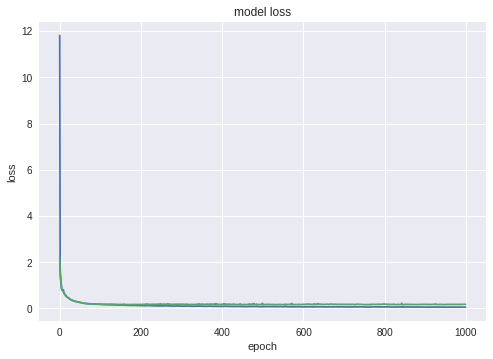

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 30 Minutes Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.2         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstmat(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_30min)))
trainY = Variable(torch.Tensor(np.array(trn_y_30min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_30min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_30min)))

testX = Variable(torch.Tensor(np.array(tst_x_30min)))
testY = Variable(torch.Tensor(np.array(tst_y_30min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_30min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = scaler.inverse_transform(y_pred)
            # targets = scaler.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.67987754 val_loss: 0.69095455 
epoch: 20 | trn_loss: 0.54920620 val_loss: 0.60607846 
epoch: 30 | trn_loss: 0.47895866 val_loss: 0.54790625 
epoch: 40 | trn_loss: 0.43328254 val_loss: 0.47655318 
epoch: 50 | trn_loss: 0.40335637 val_loss: 0.44631645 
epoch: 60 | trn_loss: 0.38267163 val_loss: 0.41354384 
epoch: 70 | trn_loss: 0.36086519 val_loss: 0.40542271 
epoch: 80 | trn_loss: 0.34249171 val_loss: 0.39724409 
epoch: 90 | trn_loss: 0.32404052 val_loss: 0.39004882 
epoch: 100 | trn_loss: 0.31392925 val_loss: 0.38024539 
epoch: 110 | trn_loss: 0.30519756 val_loss: 0.38830791 
epoch: 120 | trn_loss: 0.28920365 val_loss: 0.39656834 
epoch: 130 | trn_loss: 0.26818865 val_loss: 0.37748452 
epoch: 140 | trn_loss: 0.26426864 val_loss: 0.36427024 
epoch: 150 | trn_loss: 0.24852770 val_loss: 0.35401597 
epoch: 160 | trn_loss: 0.23680492 val_loss: 0.35648215 
epoch: 170 | trn_loss: 0.23342118 val_loss: 0.36578849 
epoch: 180 | trn_loss: 0.22188245 val_loss: 0.37604031 
e

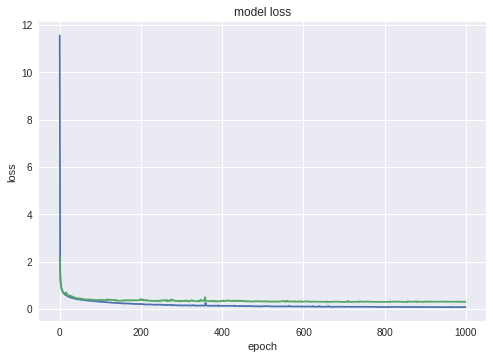

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 45 minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstmat(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_45min)))
trainY = Variable(torch.Tensor(np.array(trn_y_45min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_45min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_45min)))

testX = Variable(torch.Tensor(np.array(tst_x_45min)))
testY = Variable(torch.Tensor(np.array(tst_y_45min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_45min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = scaler.inverse_transform(y_pred)
            # targets = scaler.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("Best Model mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.86623535 val_loss: 0.83053108 
epoch: 20 | trn_loss: 0.70471843 val_loss: 0.68247487 
epoch: 30 | trn_loss: 0.61728253 val_loss: 0.59221025 
epoch: 40 | trn_loss: 0.57283905 val_loss: 0.55359078 
epoch: 50 | trn_loss: 0.53640685 val_loss: 0.52106260 
epoch: 60 | trn_loss: 0.50639157 val_loss: 0.51090041 
epoch: 70 | trn_loss: 0.48333296 val_loss: 0.49432261 
epoch: 80 | trn_loss: 0.46115654 val_loss: 0.48036475 
epoch: 90 | trn_loss: 0.44308276 val_loss: 0.46537382 
epoch: 100 | trn_loss: 0.42617242 val_loss: 0.46970389 
epoch: 110 | trn_loss: 0.41246965 val_loss: 0.48940318 
epoch: 120 | trn_loss: 0.39921718 val_loss: 0.49313149 
epoch: 130 | trn_loss: 0.38971182 val_loss: 0.45951189 
epoch: 140 | trn_loss: 0.36882341 val_loss: 0.44243970 
epoch: 150 | trn_loss: 0.35380137 val_loss: 0.44468863 
epoch: 160 | trn_loss: 0.34106812 val_loss: 0.43688206 
epoch: 170 | trn_loss: 0.32585025 val_loss: 0.45182191 
epoch: 180 | trn_loss: 0.33111344 val_loss: 0.47084776 
e

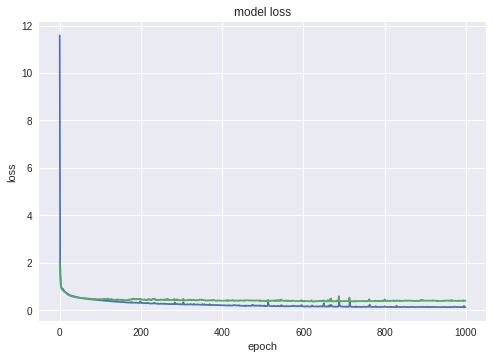

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()